# Аналитика: Применение ИИ в работе Mad Devs (v2)

Анализ результатов опроса сотрудников компании об использовании ИИ в работе.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import re
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 11
sns.set_style('whitegrid')
PALETTE = sns.color_palette('Set2', 14)
sns.set_palette(PALETTE)

df = pd.read_csv('../Применение ИИ в работе v2 (Responses).csv')

cols = {
    'role': df.columns[2],
    'grade': df.columns[3],
    'frequency': df.columns[4],
    'clarification': df.columns[5],
    'reformulation': df.columns[6],
    'interesting_tasks': df.columns[7],
    'tasks': df.columns[8],
    'benefits': df.columns[9],
    'speed': df.columns[10],
    'bugs': df.columns[11],
    'problems': df.columns[12],
    'tools': df.columns[13],
    'prompt_skills': df.columns[14],
    'workshop_attend': df.columns[15],
    'workshop_value': df.columns[16],
    'changes_vs_last_year': df.columns[17],
    'company_help': df.columns[18],
    'ai_potential': df.columns[19],
    'new_usecases': df.columns[20],
}

SHORT_ROLES = {
    'Разработчик Backend и интегрированных систем': 'Backend',
    'Разработчик Frontend': 'Frontend',
    'DevOps': 'DevOps',
    'Другое': 'Другое',
    'Тимлид / Техлид': 'Тимлид/Техлид',
    'Инженер ML / Data Science': 'ML/DS',
    'Менеджер по поставкам (DM)': 'DM',
    'Прочий менеджмент': 'Менеджмент',
    'Менеджер проектов (PM)': 'PM',
    'QA': 'QA',
    'Design': 'Design',
    'Recruiting': 'Recruiting',
    'Разработчик Mobile': 'Mobile',
    'HR': 'HR',
}
df['role'] = df[cols['role']].map(SHORT_ROLES).fillna(df[cols['role']])

SHORT_FREQ = {
    'Часто (каждый день)': 'Каждый день',
    'Постоянно (интегрировано в основной workflow, использую в IDE)': 'В IDE/workflow',
    'Запускаю ИИ в параллельном режиме для работы над несколькими задачами': 'Параллельный режим',
    'Иногда (3-4 раза в неделю)': 'Иногда',
    'Редко (1-2 раза в неделю)': 'Редко',
}
df['freq'] = df[cols['frequency']].map(SHORT_FREQ).fillna(df[cols['frequency']])

FREQ_ORDER = ['Редко', 'Иногда', 'Каждый день', 'В IDE/workflow', 'Параллельный режим']
GRADE_ORDER = ['Junior', 'Middle', 'Senior', 'Не проходил грейдинг в компании', 'Не применимо (для сотрудников отделов)']
SHORT_GRADES = {
    'Junior': 'Junior',
    'Middle': 'Middle',
    'Senior': 'Senior',
    'Не проходил грейдинг в компании': 'Без грейда',
    'Не применимо (для сотрудников отделов)': 'Н/Д (отдел)',
}
df['grade'] = df[cols['grade']].map(SHORT_GRADES).fillna(df[cols['grade']])
GRADE_ORDER_SHORT = ['Junior', 'Middle', 'Senior', 'Без грейда', 'Н/Д (отдел)']


def split_multi(series):
    all_items = []
    for val in series.dropna():
        items = [x.strip() for x in str(val).split(',') if x.strip()]
        all_items.extend(items)
    return all_items


def add_pct_labels(ax, total=None, horizontal=False):
    if horizontal:
        for p in ax.patches:
            w = p.get_width()
            if w > 0:
                t = total if total else w
                ax.annotate(f'{w:.0f} ({w/t*100:.0f}%)',
                            (w, p.get_y() + p.get_height()/2),
                            ha='left', va='center', fontsize=9,
                            xytext=(5, 0), textcoords='offset points')
    else:
        for p in ax.patches:
            h = p.get_height()
            if h > 0:
                t = total if total else h
                ax.annotate(f'{h:.0f} ({h/t*100:.0f}%)',
                            (p.get_x() + p.get_width()/2, h),
                            ha='center', va='bottom', fontsize=9)


print(f'Загружено {len(df)} ответов')

Загружено 94 ответов


## 1. Демография

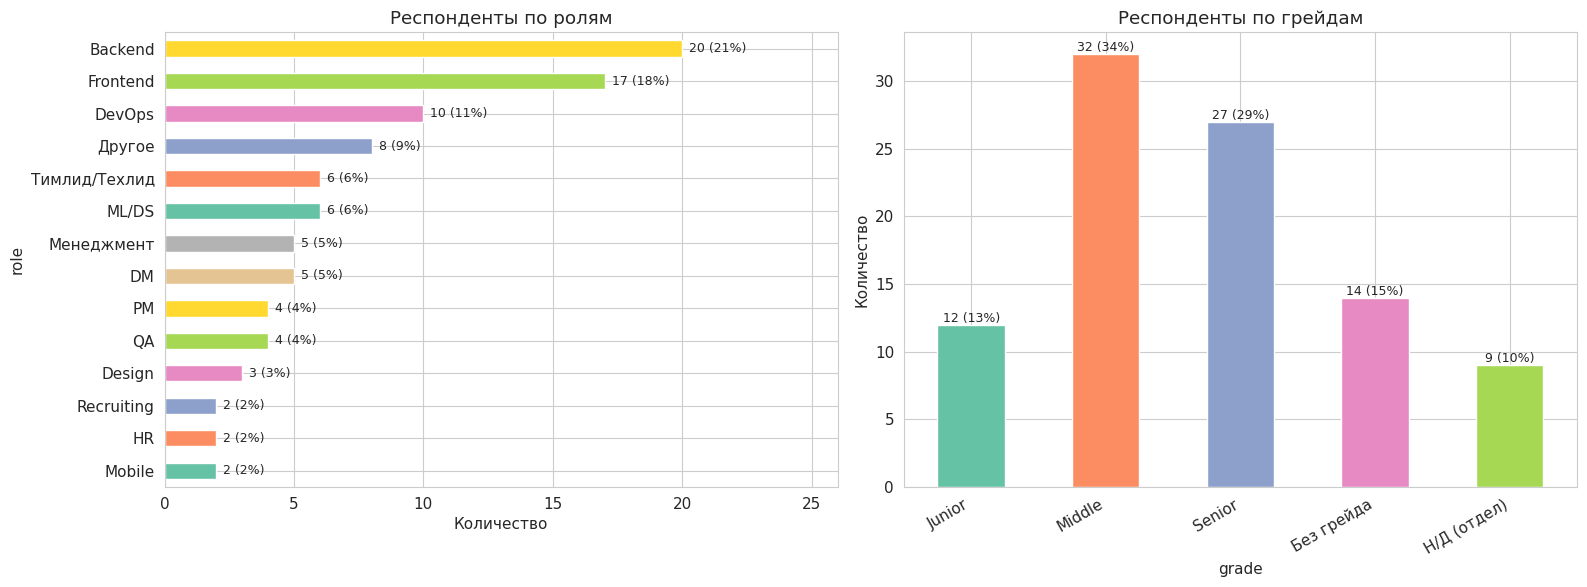

In [2]:
role_counts = df['role'].value_counts()
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax = axes[0]
role_counts.sort_values().plot.barh(ax=ax, color=PALETTE[:len(role_counts)])
ax.set_title('Респонденты по ролям')
ax.set_xlabel('Количество')
add_pct_labels(ax, total=len(df), horizontal=True)
ax.set_xlim(0, role_counts.max() * 1.3)

ax = axes[1]
grade_counts = df['grade'].value_counts().reindex(GRADE_ORDER_SHORT).dropna()
grade_counts.plot.bar(ax=ax, color=PALETTE[:len(grade_counts)])
ax.set_title('Респонденты по грейдам')
ax.set_ylabel('Количество')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
add_pct_labels(ax, total=len(df))

plt.tight_layout()
plt.show()

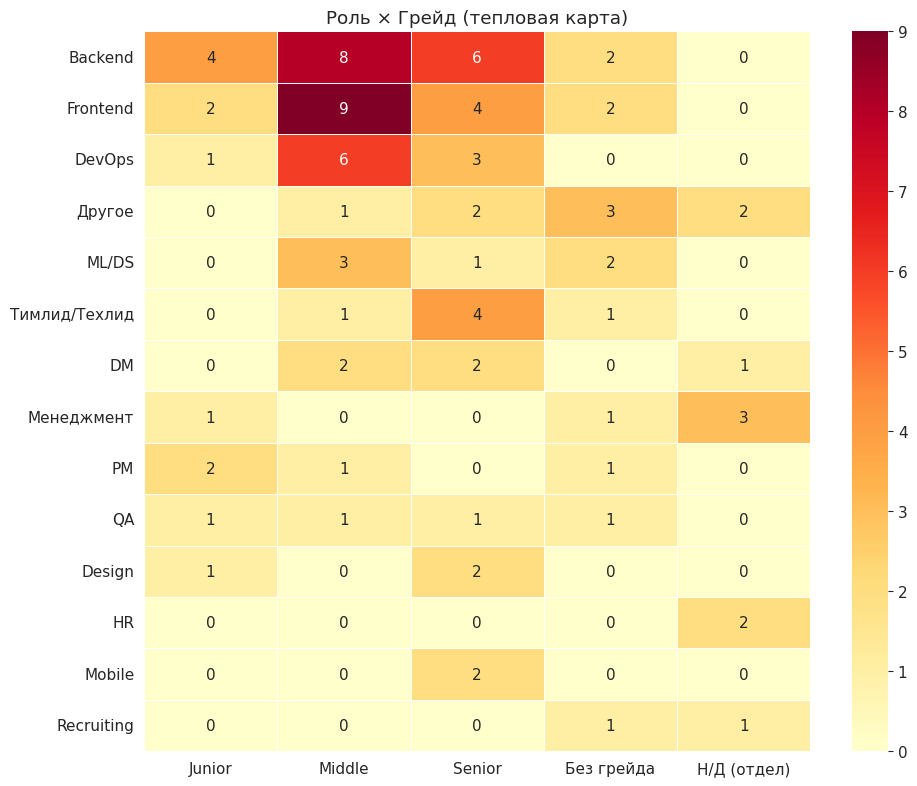

In [3]:
ct = pd.crosstab(df['role'], df['grade'])
ct = ct.reindex(columns=[g for g in GRADE_ORDER_SHORT if g in ct.columns])
ct = ct.loc[ct.sum(axis=1).sort_values(ascending=False).index]

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(ct, annot=True, fmt='d', cmap='YlOrRd', ax=ax, linewidths=0.5)
ax.set_title('Роль × Грейд (тепловая карта)')
ax.set_ylabel('')
ax.set_xlabel('')
plt.tight_layout()
plt.show()

## 2. Частота использования ИИ

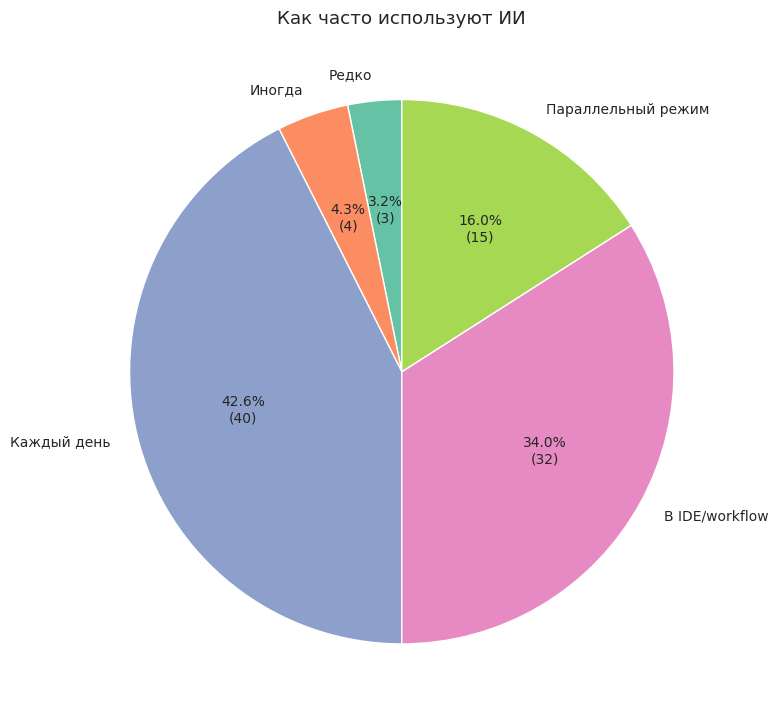

In [4]:
freq_counts = df['freq'].value_counts().reindex([f for f in FREQ_ORDER if f in df['freq'].values])

fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(
    freq_counts.values, labels=freq_counts.index,
    autopct=lambda p: f'{p:.1f}%\n({int(round(p*len(df)/100))})',
    startangle=90, colors=PALETTE[:len(freq_counts)],
    textprops={'fontsize': 10}
)
ax.set_title('Как часто используют ИИ')
plt.tight_layout()
plt.show()

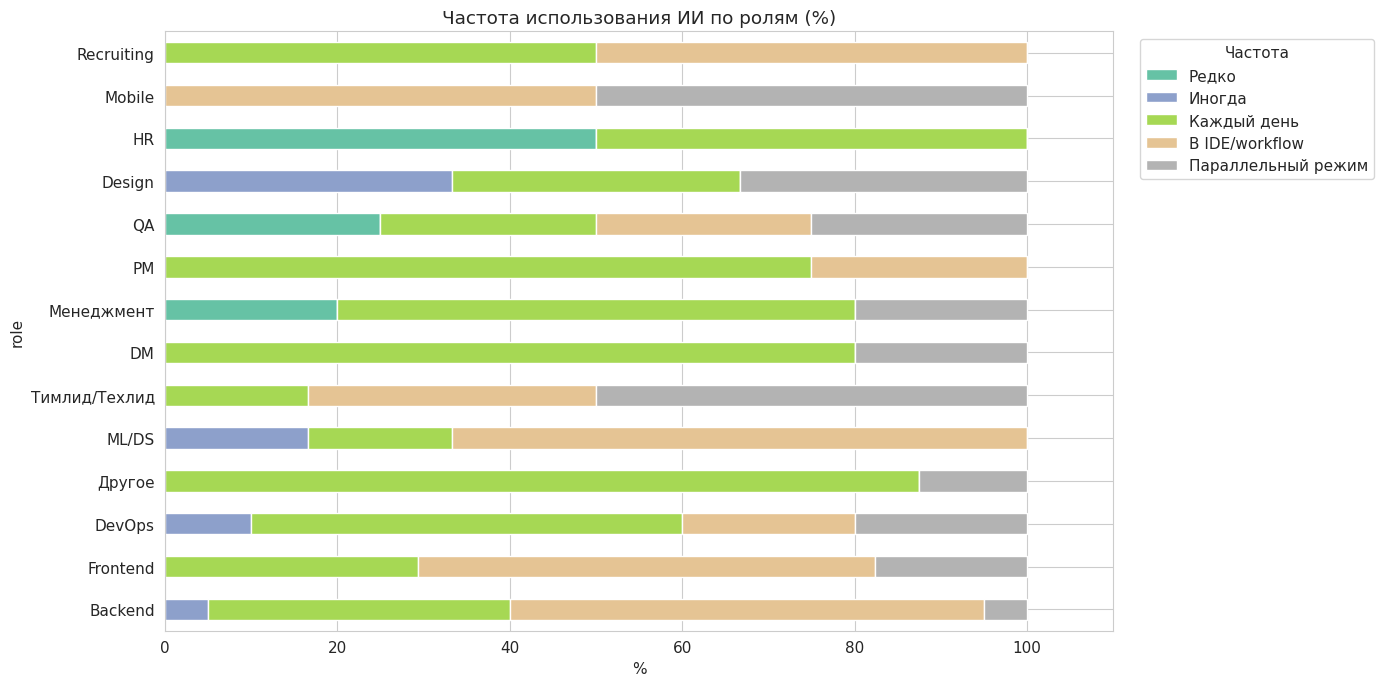

In [5]:
freq_role = pd.crosstab(df['role'], df['freq'])
freq_role = freq_role.reindex(columns=[f for f in FREQ_ORDER if f in freq_role.columns])
freq_role = freq_role.loc[freq_role.sum(axis=1).sort_values(ascending=False).index]

freq_role_pct = freq_role.div(freq_role.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots(figsize=(14, 7))
freq_role_pct.plot.barh(stacked=True, ax=ax, colormap='Set2')
ax.set_title('Частота использования ИИ по ролям (%)')
ax.set_xlabel('%')
ax.legend(title='Частота', bbox_to_anchor=(1.02, 1), loc='upper left')
ax.set_xlim(0, 110)
plt.tight_layout()
plt.show()

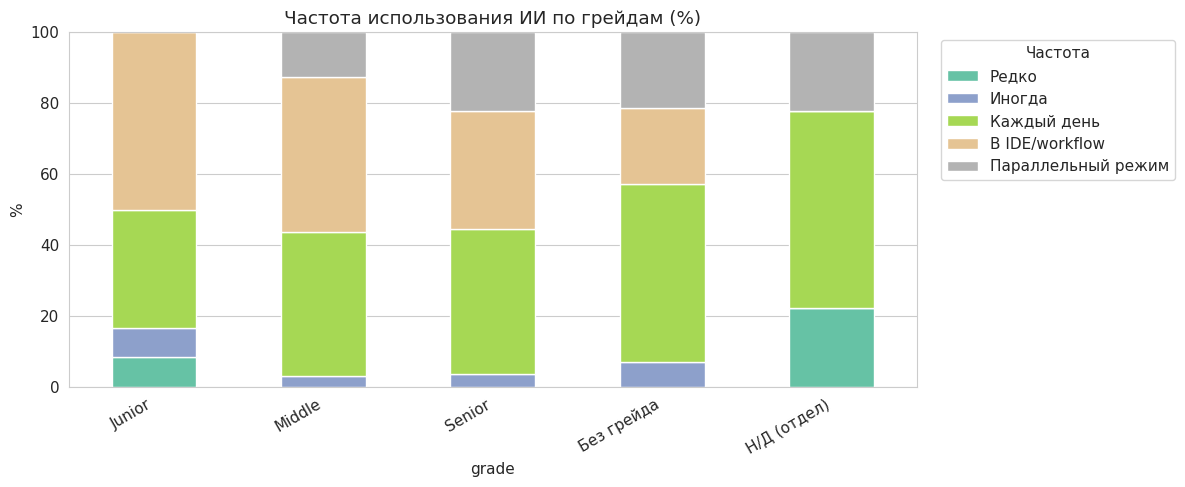

In [6]:
freq_grade = pd.crosstab(df['grade'], df['freq'])
freq_grade = freq_grade.reindex(index=[g for g in GRADE_ORDER_SHORT if g in freq_grade.index])
freq_grade = freq_grade.reindex(columns=[f for f in FREQ_ORDER if f in freq_grade.columns])

freq_grade_pct = freq_grade.div(freq_grade.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots(figsize=(12, 5))
freq_grade_pct.plot.bar(stacked=True, ax=ax, colormap='Set2')
ax.set_title('Частота использования ИИ по грейдам (%)')
ax.set_ylabel('%')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
ax.legend(title='Частота', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 3. Зрелость промпт-инжиниринга

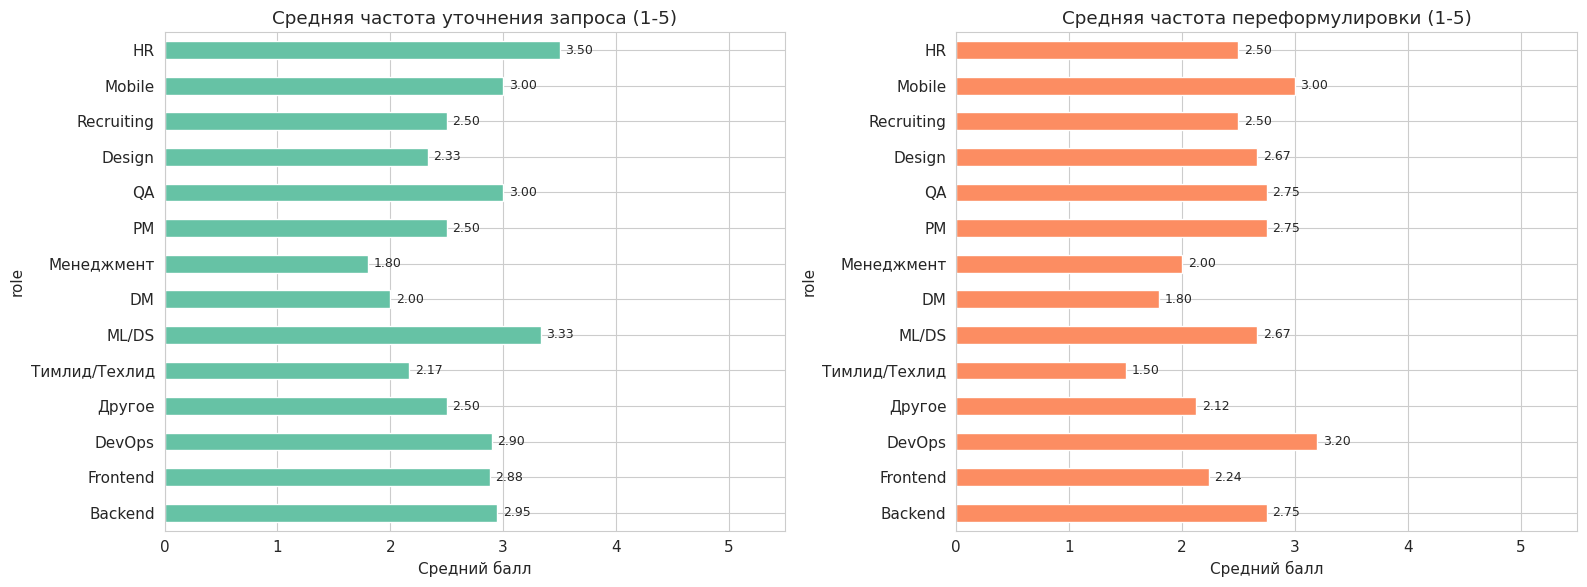

In [7]:
df['clarification'] = pd.to_numeric(df[cols['clarification']], errors='coerce')
df['reformulation'] = pd.to_numeric(df[cols['reformulation']], errors='coerce')

role_order = df['role'].value_counts().index.tolist()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

avg_clar = df.groupby('role')['clarification'].mean().reindex(role_order)
avg_clar.plot.barh(ax=axes[0], color=PALETTE[0])
axes[0].set_title('Средняя частота уточнения запроса (1-5)')
axes[0].set_xlabel('Средний балл')
axes[0].set_xlim(0, 5.5)
for i, v in enumerate(avg_clar.values):
    axes[0].text(v + 0.05, i, f'{v:.2f}', va='center', fontsize=9)

avg_ref = df.groupby('role')['reformulation'].mean().reindex(role_order)
avg_ref.plot.barh(ax=axes[1], color=PALETTE[1])
axes[1].set_title('Средняя частота переформулировки (1-5)')
axes[1].set_xlabel('Средний балл')
axes[1].set_xlim(0, 5.5)
for i, v in enumerate(avg_ref.values):
    axes[1].text(v + 0.05, i, f'{v:.2f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

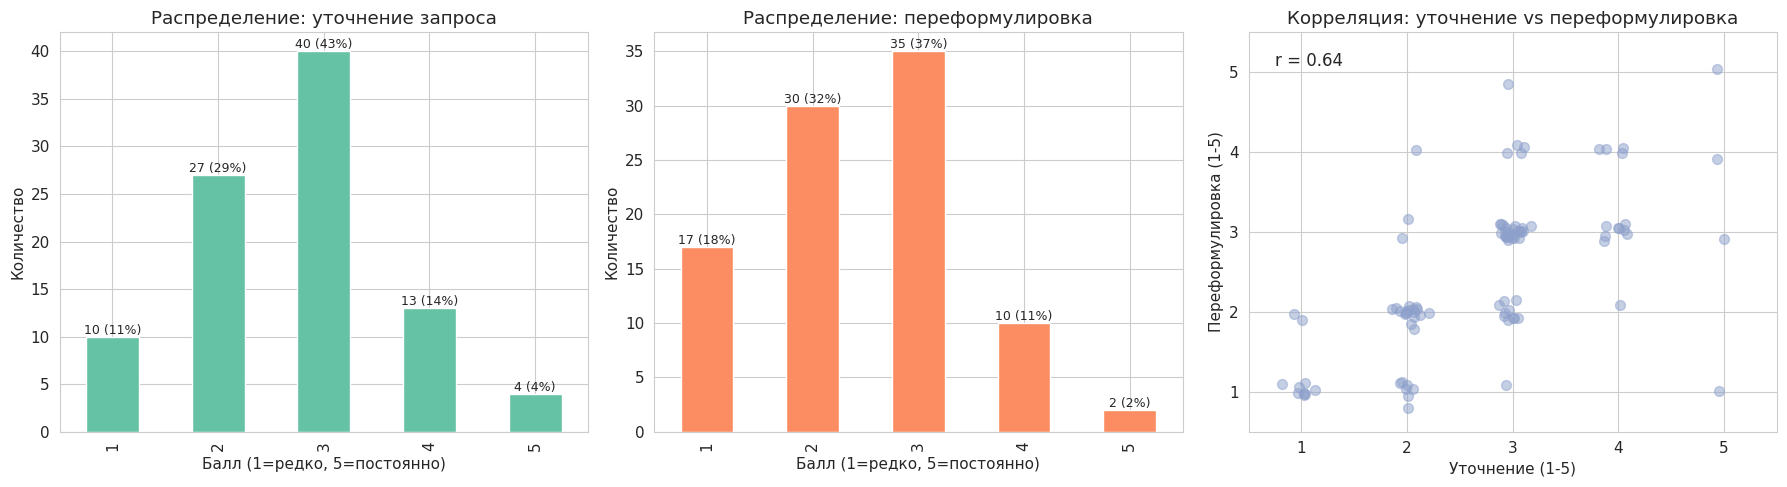

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

df['clarification'].value_counts().sort_index().plot.bar(ax=axes[0], color=PALETTE[0])
axes[0].set_title('Распределение: уточнение запроса')
axes[0].set_xlabel('Балл (1=редко, 5=постоянно)')
axes[0].set_ylabel('Количество')
add_pct_labels(axes[0], total=len(df))

df['reformulation'].value_counts().sort_index().plot.bar(ax=axes[1], color=PALETTE[1])
axes[1].set_title('Распределение: переформулировка')
axes[1].set_xlabel('Балл (1=редко, 5=постоянно)')
axes[1].set_ylabel('Количество')
add_pct_labels(axes[1], total=len(df))

ax = axes[2]
jitter_x = df['clarification'] + np.random.normal(0, 0.08, len(df))
jitter_y = df['reformulation'] + np.random.normal(0, 0.08, len(df))
ax.scatter(jitter_x, jitter_y, alpha=0.5, s=50, c=PALETTE[2])
ax.set_title('Корреляция: уточнение vs переформулировка')
ax.set_xlabel('Уточнение (1-5)')
ax.set_ylabel('Переформулировка (1-5)')
corr = df[['clarification', 'reformulation']].corr().iloc[0, 1]
ax.text(0.05, 0.95, f'r = {corr:.2f}', transform=ax.transAxes, fontsize=12, va='top')
ax.set_xlim(0.5, 5.5)
ax.set_ylim(0.5, 5.5)

plt.tight_layout()
plt.show()

## 4. Для каких задач используется ИИ

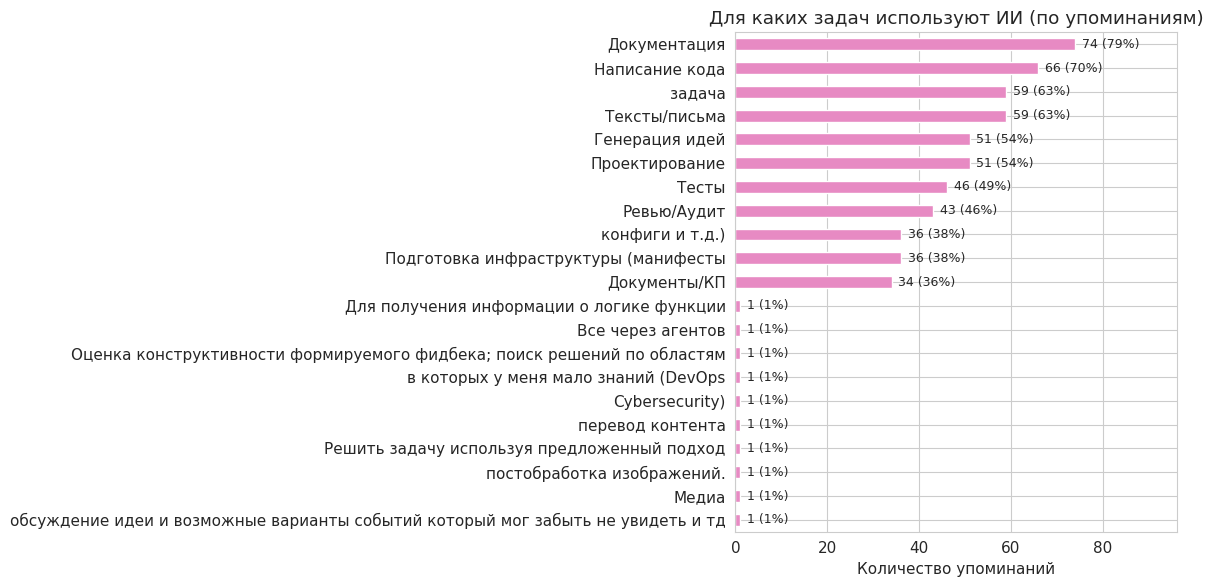

In [9]:
SHORT_TASKS = {
    'Написание кода': 'Написание кода',
    'Проектирование систем / задач': 'Проектирование',
    'Ревью кода и Аудит': 'Ревью/Аудит',
    'Составление тест-кейсов': 'Тест-кейсы',
    'unit-тестов и т.д.': 'Unit-тесты',
    'Составление документации': 'Документация',
    'Составление текста (письмо': 'Тексты',
    'задача': 'Задачи',
    'комментарий': 'Комментарии',
    'коммит': 'Коммиты',
    'ворклог)': 'Ворклоги',
    'Составление документов (коммерческое предложение': 'Документы/КП',
    'прочие документы)': 'Пр. документы',
    'Генерация идей (подготовка сценария': 'Генерация идей',
    'презентации и т.д.)': 'Презентации',
}

task_items = []
task_role_rows = []
for _, row in df.iterrows():
    val = row[cols['tasks']]
    if pd.isna(val):
        continue
    seen = set()
    for raw in str(val).split(', '):
        t = raw.strip()
        if not t:
            continue
        combined = None
        if 'код' in t.lower() and 'написание' in t.lower():
            combined = 'Написание кода'
        elif 'проектирование' in t.lower():
            combined = 'Проектирование'
        elif 'ревью' in t.lower() or 'аудит' in t.lower():
            combined = 'Ревью/Аудит'
        elif 'тест' in t.lower():
            combined = 'Тесты'
        elif 'документации' in t.lower():
            combined = 'Документация'
        elif 'текста' in t.lower() or 'письмо' in t.lower() or 'коммит' in t.lower() or 'ворклог' in t.lower() or 'комментарий' in t.lower():
            combined = 'Тексты/письма'
        elif 'документов' in t.lower() or 'коммерческое' in t.lower() or 'прочие документы' in t.lower():
            combined = 'Документы/КП'
        elif 'идей' in t.lower() or 'сценари' in t.lower() or 'презентац' in t.lower():
            combined = 'Генерация идей'
        else:
            combined = t
        if combined and combined not in seen:
            seen.add(combined)
            task_items.append(combined)
            task_role_rows.append({'task': combined, 'role': row['role']})

task_counts = pd.Series(Counter(task_items)).sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(12, 6))
task_counts.plot.barh(ax=ax, color=PALETTE[3])
ax.set_title('Для каких задач используют ИИ (по упоминаниям)')
ax.set_xlabel('Количество упоминаний')
add_pct_labels(ax, total=len(df), horizontal=True)
ax.set_xlim(0, task_counts.max() * 1.3)
plt.tight_layout()
plt.show()

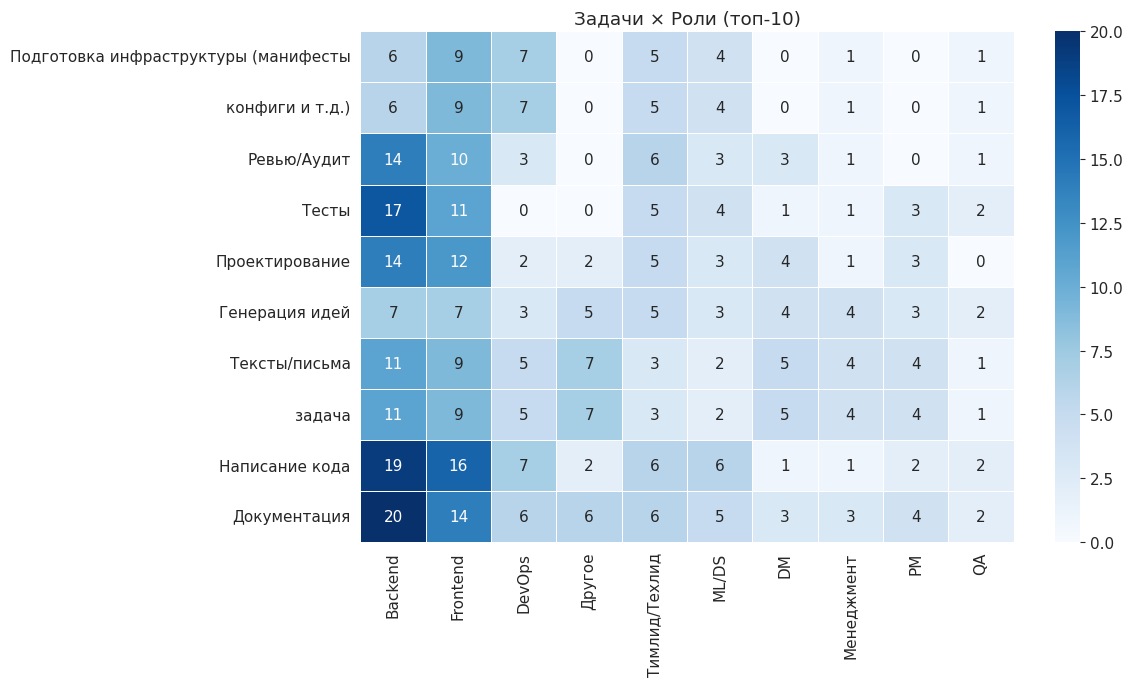

In [10]:
task_role_df = pd.DataFrame(task_role_rows)
task_role_ct = pd.crosstab(task_role_df['task'], task_role_df['role'])
top_roles = df['role'].value_counts().head(10).index
task_role_ct = task_role_ct[[r for r in top_roles if r in task_role_ct.columns]]
task_role_ct = task_role_ct.loc[task_counts.index[-10:]]

fig, ax = plt.subplots(figsize=(12, 7))
sns.heatmap(task_role_ct, annot=True, fmt='d', cmap='Blues', ax=ax, linewidths=0.5)
ax.set_title('Задачи × Роли (топ-10)')
ax.set_ylabel('')
ax.set_xlabel('')
plt.tight_layout()
plt.show()

## 5. Польза от ИИ

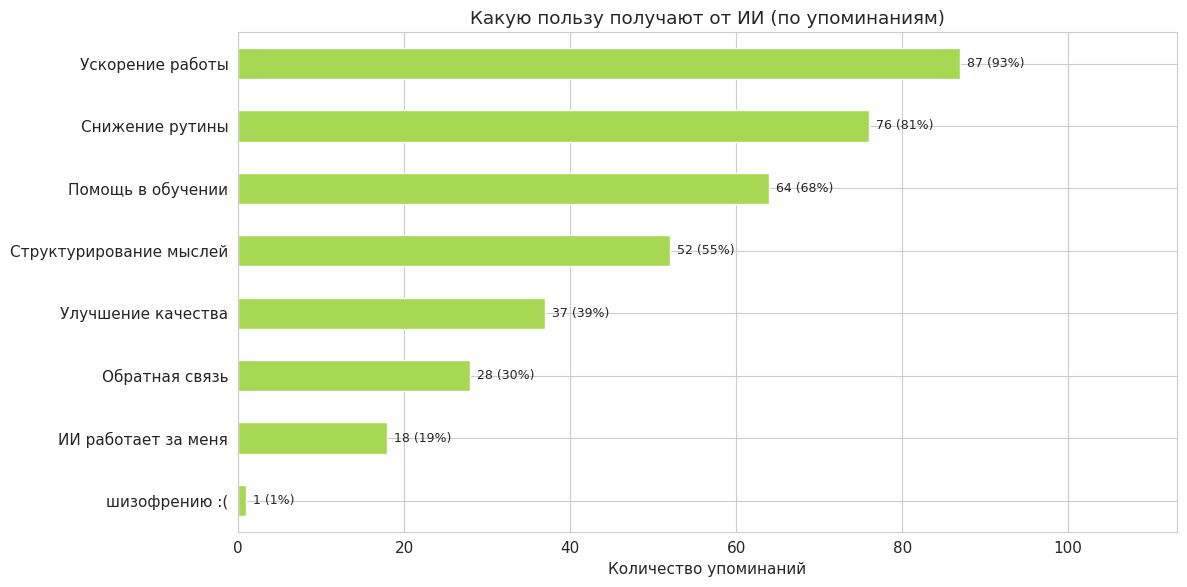

In [11]:
benefit_items = []
benefit_role_rows = []
for _, row in df.iterrows():
    val = row[cols['benefits']]
    if pd.isna(val):
        continue
    seen = set()
    for raw in str(val).split(', '):
        b = raw.strip()
        if not b or len(b) < 3:
            continue
        normalized = b
        if 'ускорение' in b.lower():
            normalized = 'Ускорение работы'
        elif 'рутин' in b.lower():
            normalized = 'Снижение рутины'
        elif 'обучен' in b.lower() or 'изучен' in b.lower():
            normalized = 'Помощь в обучении'
        elif 'структур' in b.lower():
            normalized = 'Структурирование мыслей'
        elif 'качеств' in b.lower():
            normalized = 'Улучшение качества'
        elif 'обратн' in b.lower():
            normalized = 'Обратная связь'
        elif 'работает за' in b.lower():
            normalized = 'ИИ работает за меня'
        if normalized not in seen:
            seen.add(normalized)
            benefit_items.append(normalized)
            benefit_role_rows.append({'benefit': normalized, 'role': row['role']})

benefit_counts = pd.Series(Counter(benefit_items)).sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(12, 6))
benefit_counts.plot.barh(ax=ax, color=PALETTE[4])
ax.set_title('Какую пользу получают от ИИ (по упоминаниям)')
ax.set_xlabel('Количество упоминаний')
add_pct_labels(ax, total=len(df), horizontal=True)
ax.set_xlim(0, benefit_counts.max() * 1.3)
plt.tight_layout()
plt.show()

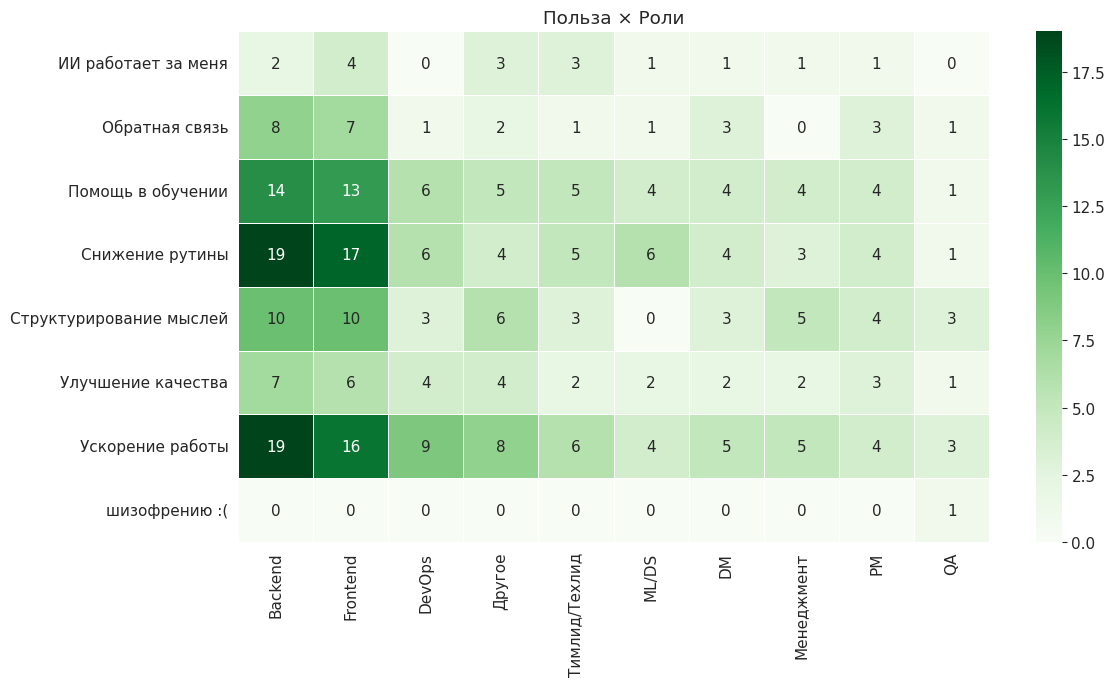

In [12]:
benefit_role_df = pd.DataFrame(benefit_role_rows)
benefit_role_ct = pd.crosstab(benefit_role_df['benefit'], benefit_role_df['role'])
benefit_role_ct = benefit_role_ct[[r for r in top_roles if r in benefit_role_ct.columns]]

fig, ax = plt.subplots(figsize=(12, 7))
sns.heatmap(benefit_role_ct, annot=True, fmt='d', cmap='Greens', ax=ax, linewidths=0.5)
ax.set_title('Польза × Роли')
ax.set_ylabel('')
ax.set_xlabel('')
plt.tight_layout()
plt.show()

## 6. Влияние на скорость и баги

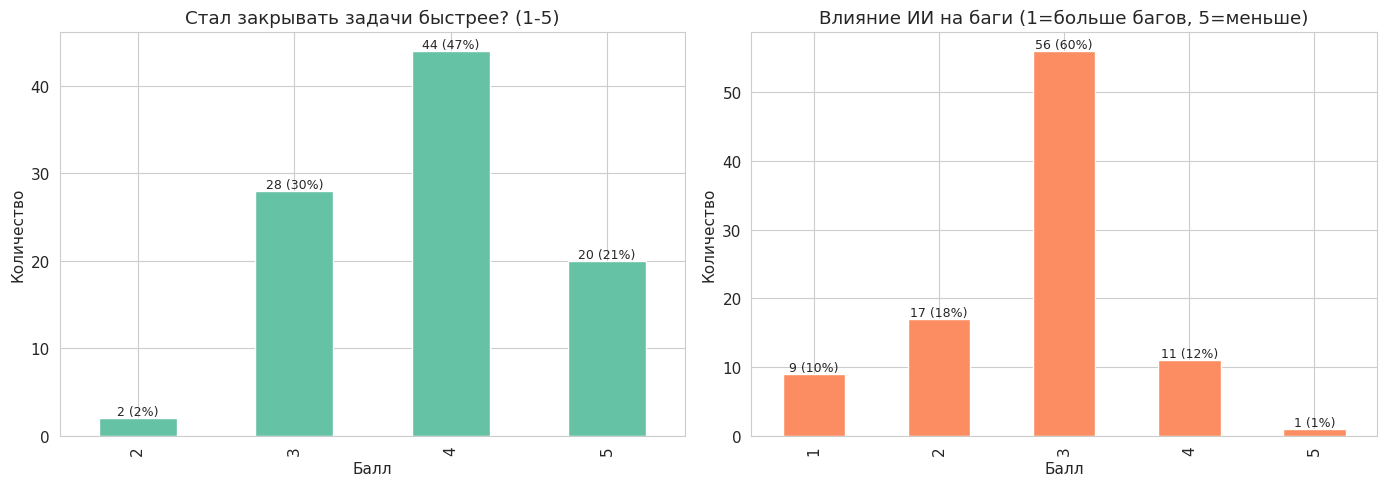

In [13]:
df['speed'] = pd.to_numeric(df[cols['speed']], errors='coerce')
df['bugs'] = pd.to_numeric(df[cols['bugs']], errors='coerce')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

speed_counts = df['speed'].value_counts().sort_index()
speed_counts.plot.bar(ax=axes[0], color=PALETTE[0])
axes[0].set_title('Стал закрывать задачи быстрее? (1-5)')
axes[0].set_xlabel('Балл')
axes[0].set_ylabel('Количество')
add_pct_labels(axes[0], total=len(df))

bugs_counts = df['bugs'].value_counts().sort_index()
bugs_counts.plot.bar(ax=axes[1], color=PALETTE[1])
axes[1].set_title('Влияние ИИ на баги (1=больше багов, 5=меньше)')
axes[1].set_xlabel('Балл')
axes[1].set_ylabel('Количество')
add_pct_labels(axes[1], total=len(df))

plt.tight_layout()
plt.show()

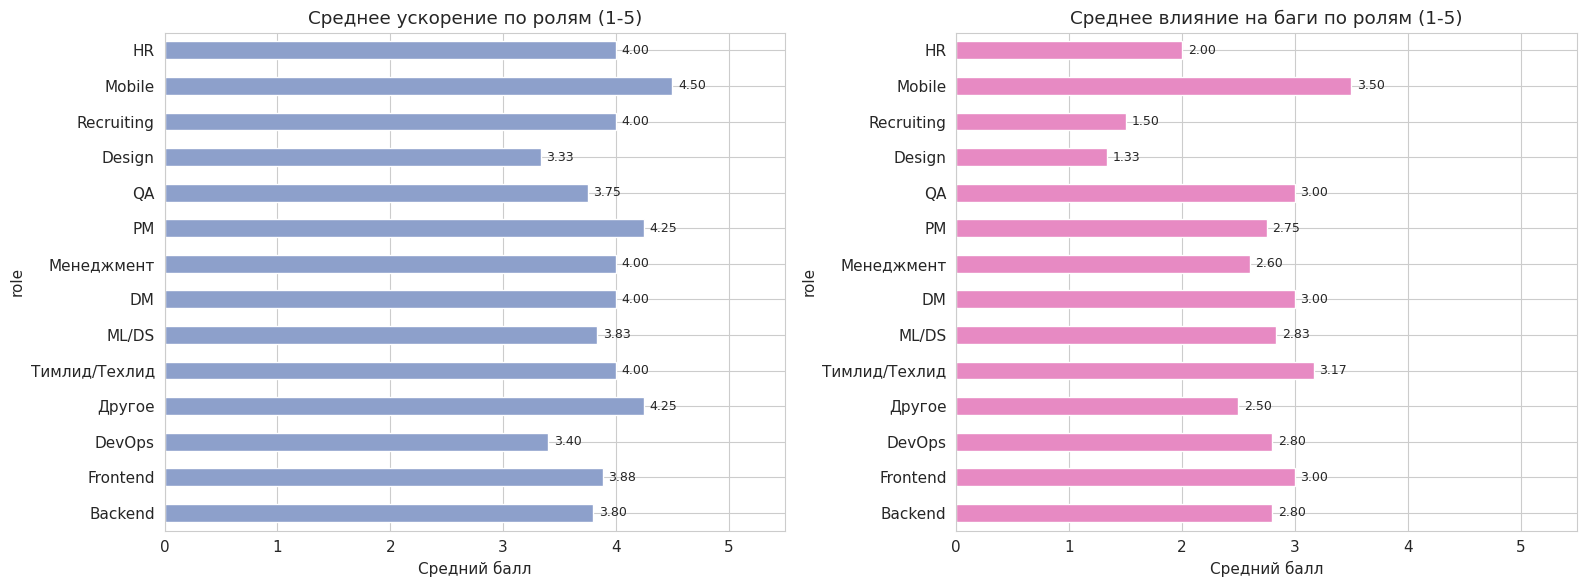

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

speed_by_role = df.groupby('role')['speed'].mean().reindex(role_order)
speed_by_role.plot.barh(ax=axes[0], color=PALETTE[2])
axes[0].set_title('Среднее ускорение по ролям (1-5)')
axes[0].set_xlabel('Средний балл')
axes[0].set_xlim(0, 5.5)
for i, v in enumerate(speed_by_role.values):
    if not np.isnan(v):
        axes[0].text(v + 0.05, i, f'{v:.2f}', va='center', fontsize=9)

bugs_by_role = df.groupby('role')['bugs'].mean().reindex(role_order)
bugs_by_role.plot.barh(ax=axes[1], color=PALETTE[3])
axes[1].set_title('Среднее влияние на баги по ролям (1-5)')
axes[1].set_xlabel('Средний балл')
axes[1].set_xlim(0, 5.5)
for i, v in enumerate(bugs_by_role.values):
    if not np.isnan(v):
        axes[1].text(v + 0.05, i, f'{v:.2f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

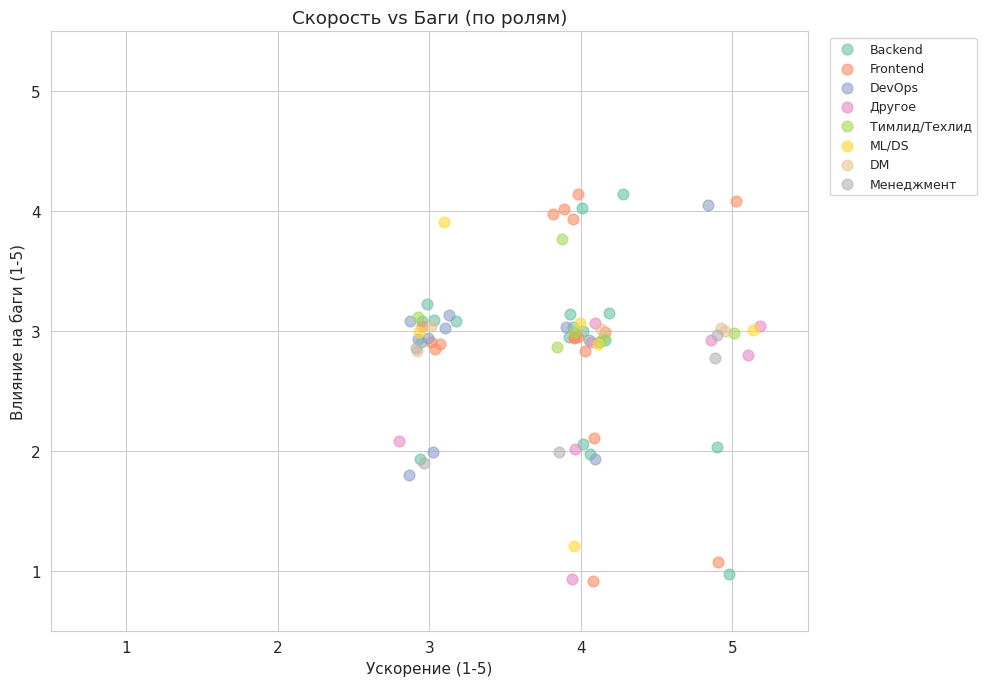

In [15]:
fig, ax = plt.subplots(figsize=(10, 7))
roles_for_scatter = df['role'].value_counts().head(8).index
mask = df['role'].isin(roles_for_scatter)
scatter_df = df[mask].dropna(subset=['speed', 'bugs'])

for i, role in enumerate(roles_for_scatter):
    rd = scatter_df[scatter_df['role'] == role]
    jx = rd['speed'] + np.random.normal(0, 0.1, len(rd))
    jy = rd['bugs'] + np.random.normal(0, 0.1, len(rd))
    ax.scatter(jx, jy, label=role, alpha=0.6, s=60, color=PALETTE[i])

ax.set_xlabel('Ускорение (1-5)')
ax.set_ylabel('Влияние на баги (1-5)')
ax.set_title('Скорость vs Баги (по ролям)')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)
ax.set_xlim(0.5, 5.5)
ax.set_ylim(0.5, 5.5)
plt.tight_layout()
plt.show()

## 7. Ландшафт ИИ-инструментов

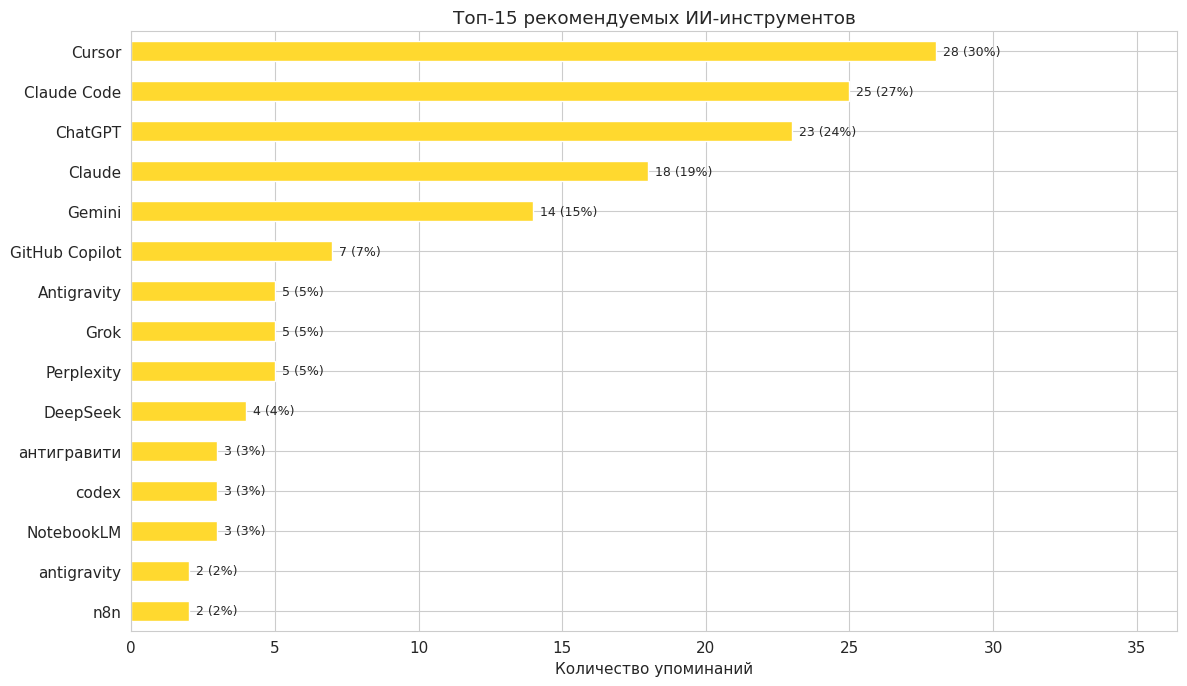

In [16]:
TOOL_NORMALIZE = {
    'claude': 'Claude',
    'клод': 'Claude',
    'claude ai': 'Claude',
    'anthropic claude': 'Claude',
    'claude code': 'Claude Code',
    'клод код': 'Claude Code',
    'claude-code': 'Claude Code',
    'claudecode': 'Claude Code',
    'cursor': 'Cursor',
    'курсор': 'Cursor',
    'chatgpt': 'ChatGPT',
    'chat gpt': 'ChatGPT',
    'чатгпт': 'ChatGPT',
    'chat-gpt': 'ChatGPT',
    'gpt': 'ChatGPT',
    'gpt4': 'ChatGPT',
    'gpt-4': 'ChatGPT',
    'gpt-4o': 'ChatGPT',
    'openai': 'ChatGPT',
    'copilot': 'GitHub Copilot',
    'github copilot': 'GitHub Copilot',
    'gemini': 'Gemini',
    'гемини': 'Gemini',
    'google gemini': 'Gemini',
    'deepseek': 'DeepSeek',
    'deep seek': 'DeepSeek',
    'perplexity': 'Perplexity',
    'перплексити': 'Perplexity',
    'windsurf': 'Windsurf',
    'codeium': 'Codeium',
    'midjourney': 'Midjourney',
    'миджорни': 'Midjourney',
    'v0': 'v0',
    'grok': 'Grok',
    'грок': 'Grok',
    'bolt': 'Bolt',
    'bolt.new': 'Bolt',
    'lovable': 'Lovable',
    'deepl': 'DeepL',
    'fireflies': 'Fireflies',
    'notion ai': 'Notion AI',
    'notion': 'Notion AI',
    'cline': 'Cline',
    'roo code': 'Roo Code',
    'roo': 'Roo Code',
    'aider': 'Aider',
    'suno': 'Suno',
    'dall-e': 'DALL-E',
    'dalle': 'DALL-E',
    'stable diffusion': 'Stable Diffusion',
    'supermaven': 'Supermaven',
}

tool_items = []
tool_role_rows = []
for _, row in df.iterrows():
    val = row[cols['tools']]
    if pd.isna(val):
        continue
    parts = re.split(r'[,;/\n]+', str(val))
    seen = set()
    for p in parts:
        t = p.strip().strip('.')
        if not t or len(t) < 2:
            continue
        key = t.lower().strip()
        normalized = TOOL_NORMALIZE.get(key, t.strip())
        if normalized.lower() not in seen:
            seen.add(normalized.lower())
            tool_items.append(normalized)
            tool_role_rows.append({'tool': normalized, 'role': row['role']})

tool_counts = pd.Series(Counter(tool_items)).sort_values(ascending=True)
top_tools = tool_counts.tail(15)

fig, ax = plt.subplots(figsize=(12, 7))
top_tools.plot.barh(ax=ax, color=PALETTE[5])
ax.set_title('Топ-15 рекомендуемых ИИ-инструментов')
ax.set_xlabel('Количество упоминаний')
add_pct_labels(ax, total=len(df), horizontal=True)
ax.set_xlim(0, top_tools.max() * 1.3)
plt.tight_layout()
plt.show()

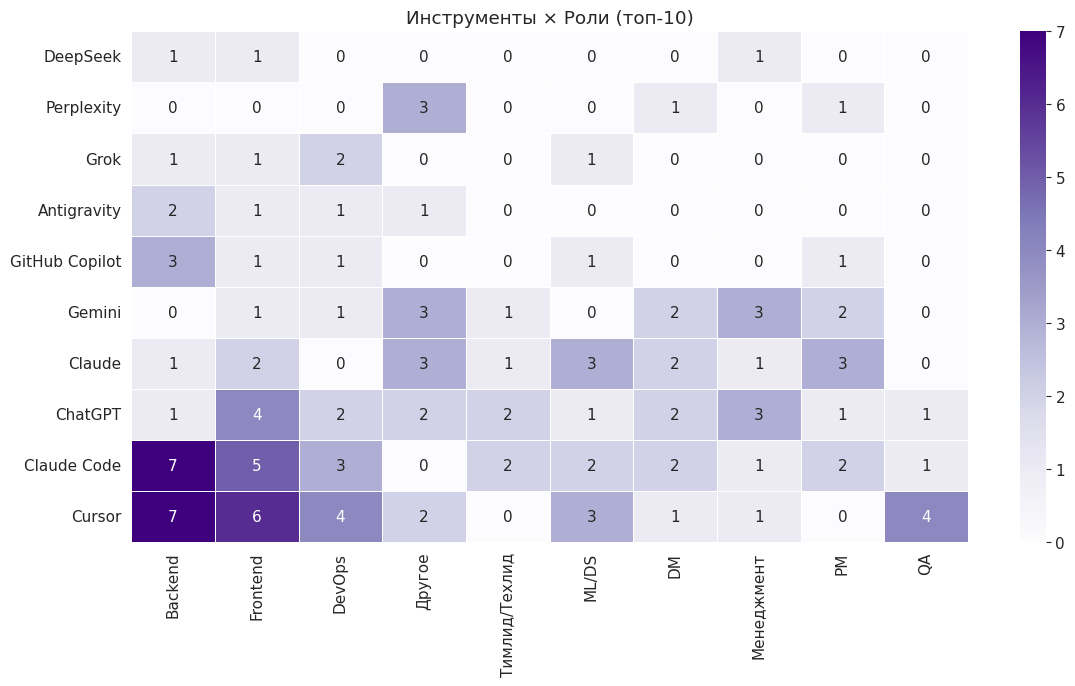

In [17]:
tool_role_df = pd.DataFrame(tool_role_rows)
top_tool_names = tool_counts.tail(10).index.tolist()
tool_role_ct = pd.crosstab(tool_role_df['tool'], tool_role_df['role'])
tool_role_ct = tool_role_ct.loc[[t for t in top_tool_names if t in tool_role_ct.index]]
tool_role_ct = tool_role_ct[[r for r in top_roles if r in tool_role_ct.columns]]

fig, ax = plt.subplots(figsize=(12, 7))
sns.heatmap(tool_role_ct, annot=True, fmt='d', cmap='Purples', ax=ax, linewidths=0.5)
ax.set_title('Инструменты × Роли (топ-10)')
ax.set_ylabel('')
ax.set_xlabel('')
plt.tight_layout()
plt.show()

## 8. Развитие навыков промпт-инжиниринга

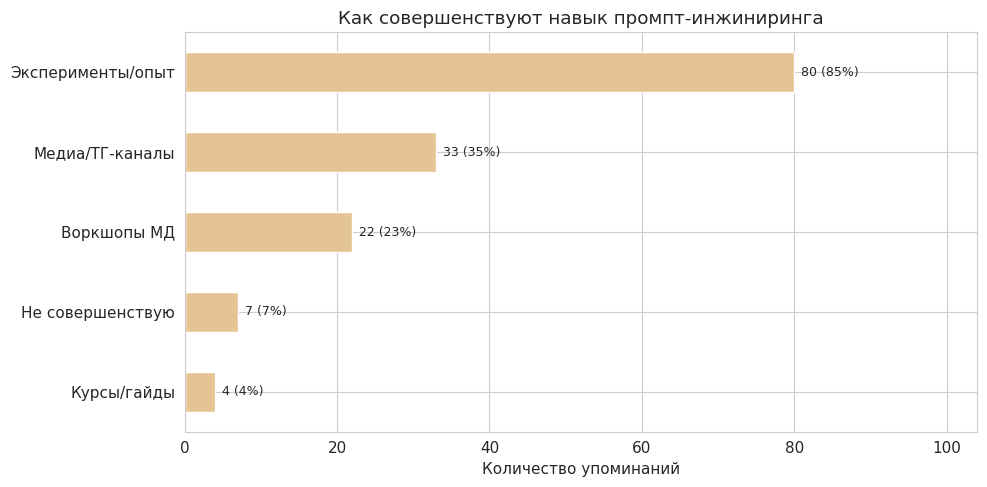

In [18]:
SHORT_SKILLS = {
    'Экспериментирую и ориентируюсь на свой предыдущий опыт': 'Эксперименты/опыт',
    'Подписан на медиа (ютую': 'Медиа/ТГ-каналы',
    'тг-каналы': 'Медиа/ТГ-каналы',
    'форумы и прочее)': 'Медиа/ТГ-каналы',
    'Воркшопы МД': 'Воркшопы МД',
    'Не совершенствую': 'Не совершенствую',
    'Изучаю промпт-инжиниринг целенаправленно (курсы': 'Курсы/гайды',
    'гайды)': 'Курсы/гайды',
}

skill_items = []
skill_role_rows = []
for _, row in df.iterrows():
    val = row[cols['prompt_skills']]
    if pd.isna(val):
        continue
    seen = set()
    text = str(val)
    if 'Не совершенствую' in text:
        if 'Не совершенствую' not in seen:
            seen.add('Не совершенствую')
            skill_items.append('Не совершенствую')
            skill_role_rows.append({'skill': 'Не совершенствую', 'role': row['role']})
    if 'Экспериментирую' in text:
        s = 'Эксперименты/опыт'
        if s not in seen:
            seen.add(s)
            skill_items.append(s)
            skill_role_rows.append({'skill': s, 'role': row['role']})
    if 'Подписан на медиа' in text or 'тг-канал' in text:
        s = 'Медиа/ТГ-каналы'
        if s not in seen:
            seen.add(s)
            skill_items.append(s)
            skill_role_rows.append({'skill': s, 'role': row['role']})
    if 'Воркшопы МД' in text:
        s = 'Воркшопы МД'
        if s not in seen:
            seen.add(s)
            skill_items.append(s)
            skill_role_rows.append({'skill': s, 'role': row['role']})
    if 'целенаправленно' in text or 'курсы' in text.lower() or 'гайды' in text.lower():
        s = 'Курсы/гайды'
        if s not in seen:
            seen.add(s)
            skill_items.append(s)
            skill_role_rows.append({'skill': s, 'role': row['role']})

skill_counts = pd.Series(Counter(skill_items)).sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(10, 5))
skill_counts.plot.barh(ax=ax, color=PALETTE[6])
ax.set_title('Как совершенствуют навык промпт-инжиниринга')
ax.set_xlabel('Количество упоминаний')
add_pct_labels(ax, total=len(df), horizontal=True)
ax.set_xlim(0, skill_counts.max() * 1.3)
plt.tight_layout()
plt.show()

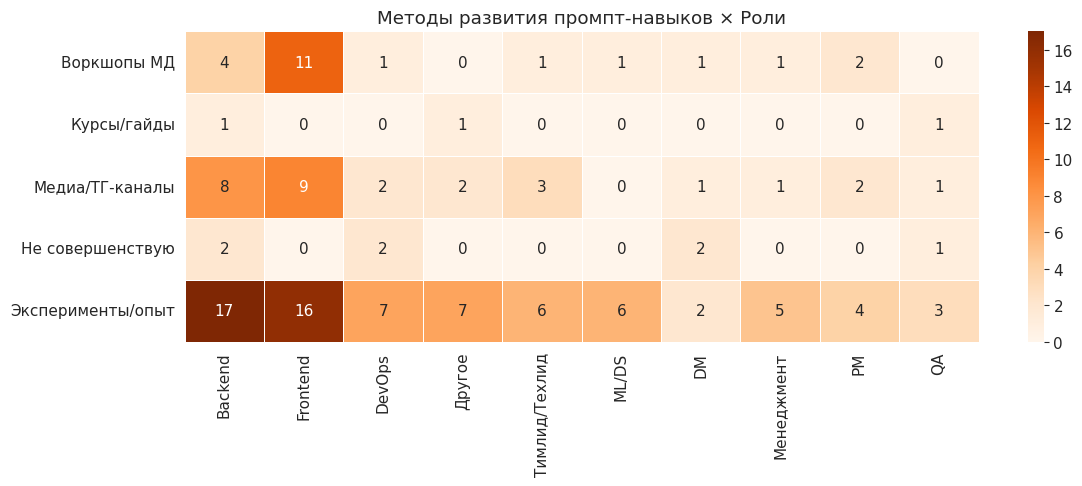

In [19]:
skill_role_df = pd.DataFrame(skill_role_rows)
skill_role_ct = pd.crosstab(skill_role_df['skill'], skill_role_df['role'])
skill_role_ct = skill_role_ct[[r for r in top_roles if r in skill_role_ct.columns]]

fig, ax = plt.subplots(figsize=(12, 5))
sns.heatmap(skill_role_ct, annot=True, fmt='d', cmap='Oranges', ax=ax, linewidths=0.5)
ax.set_title('Методы развития промпт-навыков × Роли')
ax.set_ylabel('')
ax.set_xlabel('')
plt.tight_layout()
plt.show()

## 9. Воркшопы

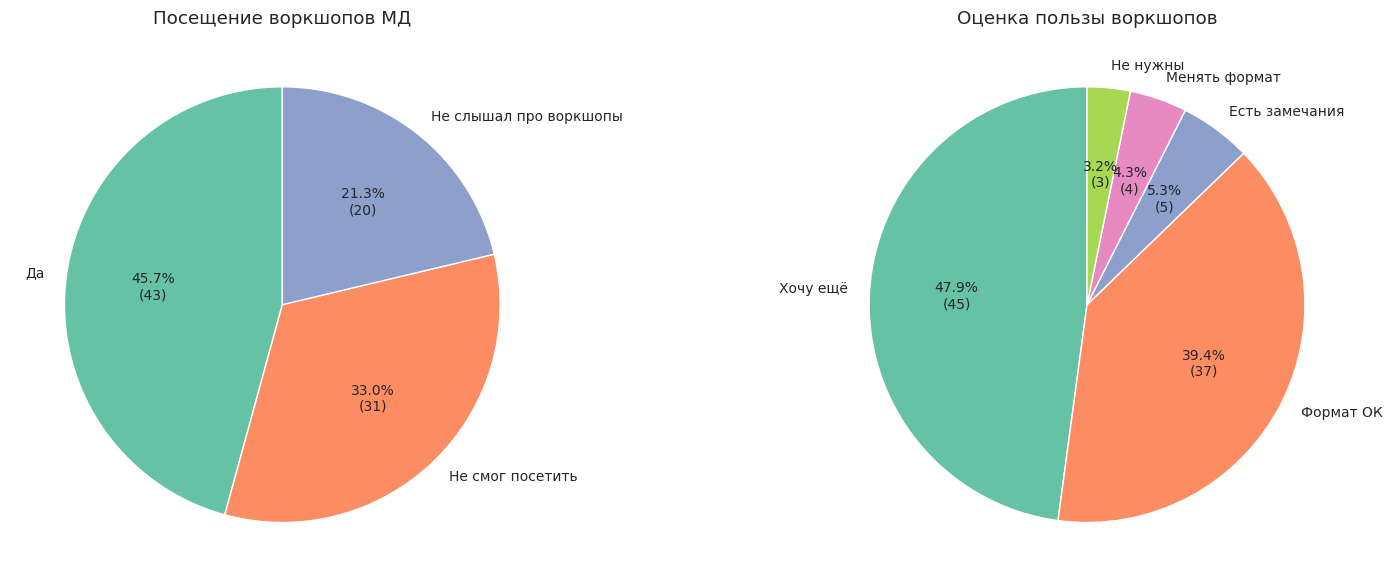

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

attend = df[cols['workshop_attend']].value_counts()
axes[0].pie(
    attend.values, labels=attend.index,
    autopct=lambda p: f'{p:.1f}%\n({int(round(p*len(df)/100))})',
    startangle=90, colors=PALETTE[:len(attend)],
    textprops={'fontsize': 10}
)
axes[0].set_title('Посещение воркшопов МД')

value = df[cols['workshop_value']].value_counts()
short_value = {
    'Да, хочу еще воркшопов': 'Хочу ещё',
    'Да, текущий формат полезен': 'Формат ОК',
    'Да, но есть замечания': 'Есть замечания',
    'Нет, нужно менять формат': 'Менять формат',
    'Нет, воркшопы не нужны': 'Не нужны',
}
value.index = [short_value.get(v, v) for v in value.index]
axes[1].pie(
    value.values, labels=value.index,
    autopct=lambda p: f'{p:.1f}%\n({int(round(p*len(df)/100))})',
    startangle=90, colors=PALETTE[:len(value)],
    textprops={'fontsize': 10}
)
axes[1].set_title('Оценка пользы воркшопов')

plt.tight_layout()
plt.show()

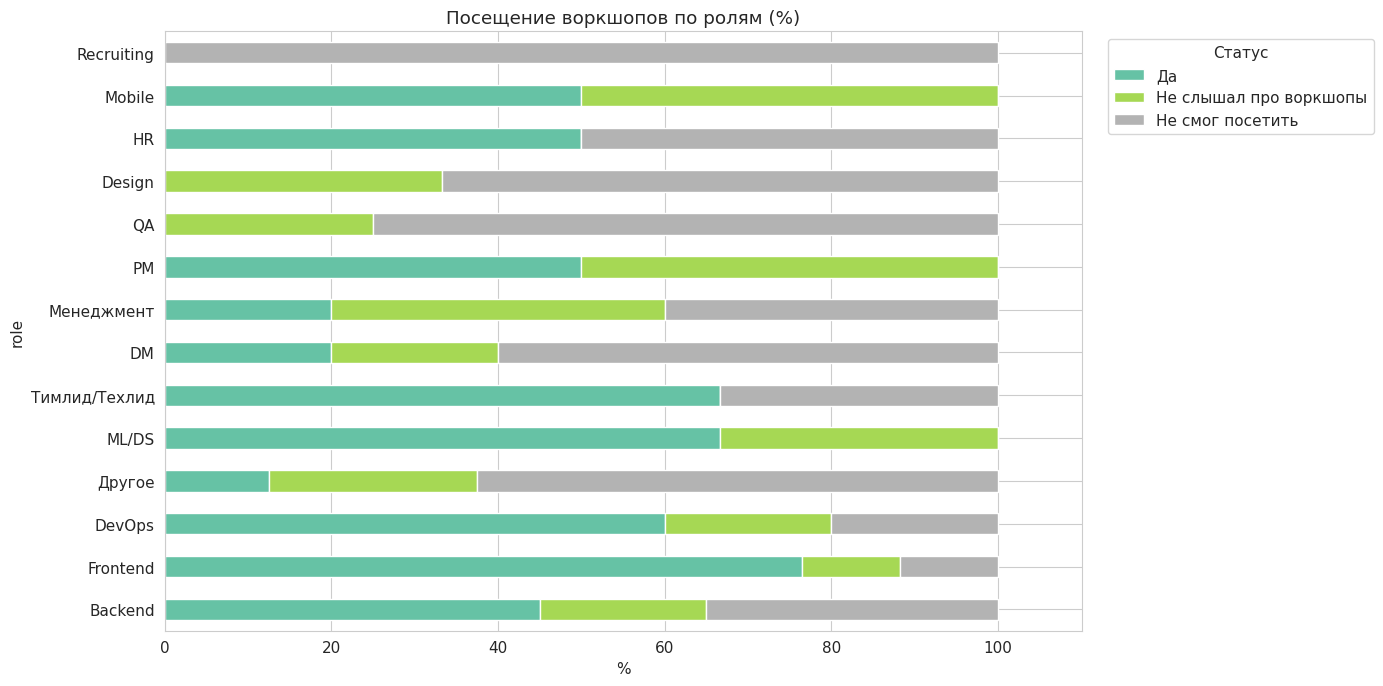

In [21]:
attend_role = pd.crosstab(df['role'], df[cols['workshop_attend']])
attend_role = attend_role.loc[attend_role.sum(axis=1).sort_values(ascending=False).index]
attend_role_pct = attend_role.div(attend_role.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots(figsize=(14, 7))
attend_role_pct.plot.barh(stacked=True, ax=ax, colormap='Set2')
ax.set_title('Посещение воркшопов по ролям (%)')
ax.set_xlabel('%')
ax.legend(title='Статус', bbox_to_anchor=(1.02, 1), loc='upper left')
ax.set_xlim(0, 110)
plt.tight_layout()
plt.show()

## 10. Потенциал ИИ (перспектива 2 года)

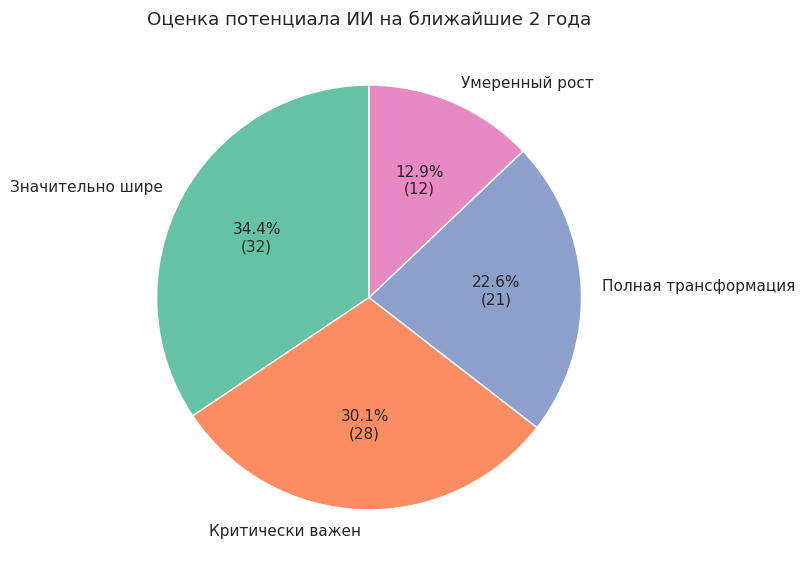

In [22]:
potential = df[cols['ai_potential']].value_counts()
short_potential = {
    'ИИ станет использоваться значительно шире и чаще': 'Значительно шире',
    'ИИ станет критически важен': 'Критически важен',
    'Полная трансформация профессии': 'Полная трансформация',
    'Умеренный рост применения': 'Умеренный рост',
}

fig, ax = plt.subplots(figsize=(8, 8))
labels = [short_potential.get(v, v) for v in potential.index]
ax.pie(
    potential.values, labels=labels,
    autopct=lambda p: f'{p:.1f}%\n({int(round(p*len(df)/100))})',
    startangle=90, colors=PALETTE[:len(potential)],
    textprops={'fontsize': 11}
)
ax.set_title('Оценка потенциала ИИ на ближайшие 2 года')
plt.tight_layout()
plt.show()

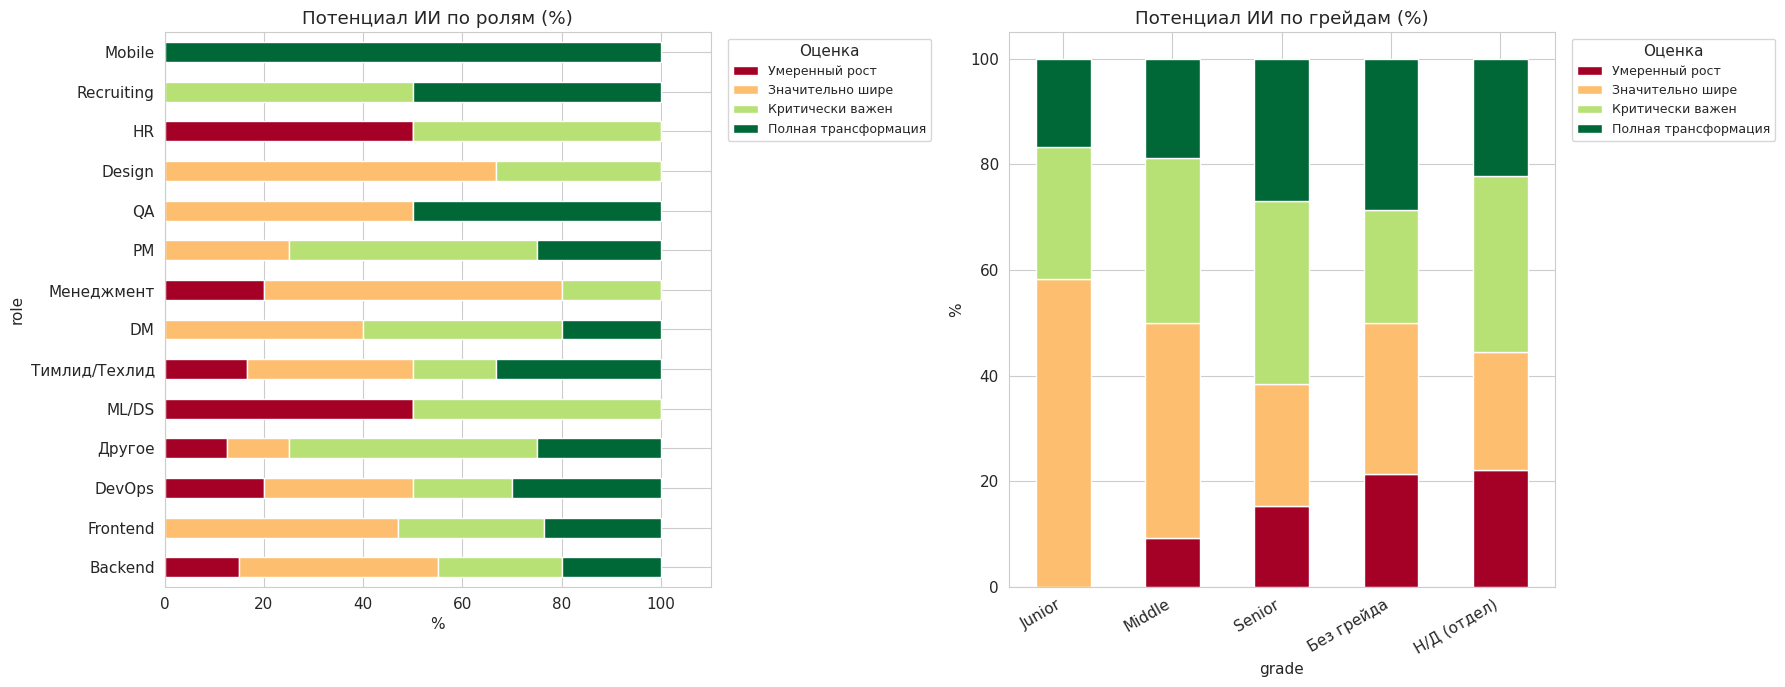

In [23]:
df['potential_short'] = df[cols['ai_potential']].map(short_potential).fillna(df[cols['ai_potential']])
POTENTIAL_ORDER = ['Умеренный рост', 'Значительно шире', 'Критически важен', 'Полная трансформация']

pot_role = pd.crosstab(df['role'], df['potential_short'])
pot_role = pot_role.reindex(columns=[p for p in POTENTIAL_ORDER if p in pot_role.columns])
pot_role = pot_role.loc[pot_role.sum(axis=1).sort_values(ascending=False).index]
pot_role_pct = pot_role.div(pot_role.sum(axis=1), axis=0) * 100

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

pot_role_pct.plot.barh(stacked=True, ax=axes[0], colormap='RdYlGn')
axes[0].set_title('Потенциал ИИ по ролям (%)')
axes[0].set_xlabel('%')
axes[0].legend(title='Оценка', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)
axes[0].set_xlim(0, 110)

pot_grade = pd.crosstab(df['grade'], df['potential_short'])
pot_grade = pot_grade.reindex(index=[g for g in GRADE_ORDER_SHORT if g in pot_grade.index])
pot_grade = pot_grade.reindex(columns=[p for p in POTENTIAL_ORDER if p in pot_grade.columns])
pot_grade_pct = pot_grade.div(pot_grade.sum(axis=1), axis=0) * 100

pot_grade_pct.plot.bar(stacked=True, ax=axes[1], colormap='RdYlGn')
axes[1].set_title('Потенциал ИИ по грейдам (%)')
axes[1].set_ylabel('%')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=30, ha='right')
axes[1].legend(title='Оценка', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)

plt.tight_layout()
plt.show()

## 11. Проблемы и опасения (анализ текста)

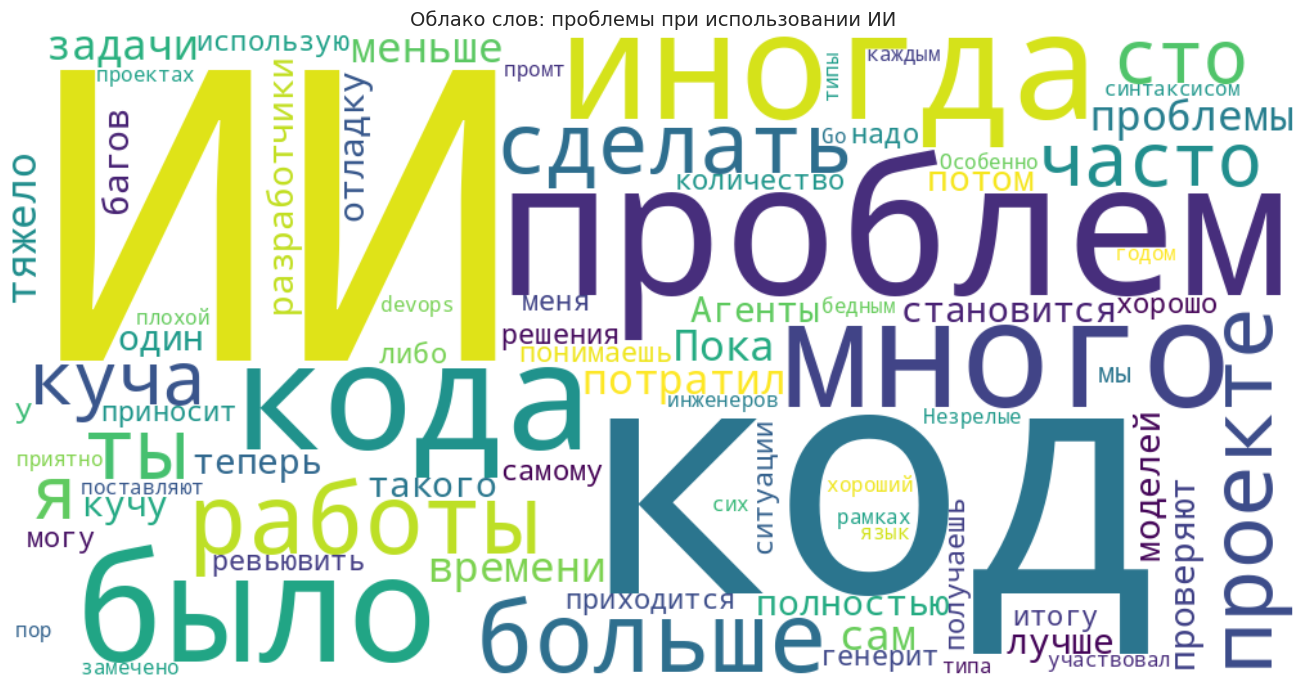


Ответов с описанием проблем: 39

Примеры ответов:
  1. Незрелые разработчики поставляют плохой код и даже не проверяют его
  2. В рамках работы devops инженеров в проектах, где я участвовал, такого замечено не было
  3. С каждым годом становится лучше и лучше. Особенно приятно на язык с бедным синтаксисом типа Go и где есть типы
  4. ИИ до сих пор очень часто даже на хороший промт выдает галлюцинацию. 
  5. Подобных эпизодов не возникало
  6. статьи легко считываются, если полностью написаны ИИ
  7. 1. да. когда сто вайбит кучу кода, просит интегрировать в процесс. а там куча багов из за того что оттестировал на одном кейсе
2. некоторые коллеги сл
  8. ХЗ как разруливать когда несколько человек работают с агентами. Агенты щупают один и тот же код, а потом силди и сливаю всё в нерабочий код
  9. Бывают траты на инфру при развертывании локальных моделей. Вручную я бы потратил много времени на локальную отладку но пришел бы к решению. С использо
  10. После ИИ код приходится ревьювить и 

In [24]:
from wordcloud import WordCloud

STOP_WORDS_RU = {
    'и', 'в', 'на', 'с', 'по', 'для', 'не', 'что', 'это', 'как', 'но',
    'он', 'она', 'они', 'его', 'её', 'их', 'то', 'от', 'из', 'к', 'за',
    'при', 'до', 'или', 'а', 'же', 'бы', 'ли', 'так', 'уже', 'ещё',
    'еще', 'да', 'нет', 'без', 'об', 'ко', 'чтобы', 'когда', 'если',
    'тоже', 'более', 'менее', 'очень', 'может', 'нужно', 'свой', 'мой',
    'который', 'которая', 'которые', 'которого', 'быть', 'был', 'была',
    'были', 'есть', 'будет', 'через', 'после', 'перед', 'себя', 'себе',
    'чем', 'где', 'всё', 'все', 'вот', 'над', 'под', 'между', 'этот',
    'эта', 'эти', 'того', 'этого', 'тем', 'там', 'тут', 'потому',
    'поэтому', 'также', 'только', 'просто', 'даже', 'можно',
}

problems_text = df[cols['problems']].dropna().astype(str)
problems_text = problems_text[~problems_text.isin(['-', 'нет', 'Нет', '-\n', ''])]

all_problems_text = ' '.join(problems_text.values)

if len(all_problems_text.strip()) > 20:
    wc = WordCloud(
        width=1000, height=500,
        background_color='white',
        stopwords=STOP_WORDS_RU,
        max_words=80,
        collocations=False,
    ).generate(all_problems_text)

    fig, ax = plt.subplots(figsize=(14, 7))
    ax.imshow(wc, interpolation='bilinear')
    ax.axis('off')
    ax.set_title('Облако слов: проблемы при использовании ИИ', fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print('Недостаточно данных для облака слов')

print(f'\nОтветов с описанием проблем: {len(problems_text)}')
print('\nПримеры ответов:')
for i, t in enumerate(problems_text.head(10).values, 1):
    if t.strip() not in ['-', 'нет', 'Нет', '']:
        print(f'  {i}. {t[:150]}')

## 12. Ключевые выводы и рекомендации

In [25]:
total = len(df)
daily_plus = len(df[df['freq'].isin(['Каждый день', 'В IDE/workflow', 'Параллельный режим'])])
daily_pct = daily_plus / total * 100

avg_speed = df['speed'].mean()
avg_bugs = df['bugs'].mean()

top_tool = tool_counts.idxmax()
top_tool_count = tool_counts.max()

attended_pct = (df[cols['workshop_attend']] == 'Да').sum() / total * 100
want_more = (df[cols['workshop_value']] == 'Да, хочу еще воркшопов').sum() / total * 100

critical_transform = len(df[df['potential_short'].isin(['Критически важен', 'Полная трансформация'])])
critical_pct = critical_transform / total * 100

from IPython.display import Markdown, display

summary = f"""### Основные показатели

| Метрика | Значение |
|---|---|
| Всего респондентов | **{total}** |
| Используют ИИ ежедневно+ | **{daily_plus}** ({daily_pct:.0f}%) |
| Средний балл ускорения (1-5) | **{avg_speed:.2f}** |
| Средний балл влияния на баги (1-5) | **{avg_bugs:.2f}** |
| Самый популярный инструмент | **{top_tool}** ({top_tool_count} упоминаний) |
| Посещали воркшопы | **{attended_pct:.0f}%** |
| Хотят ещё воркшопов | **{want_more:.0f}%** |
| Считают ИИ критически важным / трансформирующим | **{critical_transform}** ({critical_pct:.0f}%) |

---

### Ключевые выводы

1. **Массовое внедрение ИИ**: {daily_pct:.0f}% сотрудников используют ИИ ежедневно или чаще — ИИ стал стандартным инструментом.

2. **Ускорение работы**: средний балл {avg_speed:.2f}/5 показывает заметный эффект на скорость закрытия задач.

3. **Нейтральное влияние на баги**: средний балл {avg_bugs:.2f}/5 — ИИ в целом не увеличивает и не сильно снижает количество багов.

4. **Инструменты**: {top_tool} лидирует, экосистема Anthropic (Claude + Claude Code) доминирует. Cursor также популярен.

5. **Воркшопы востребованы**: {want_more:.0f}% хотят больше воркшопов — высокий запрос на обучение.

6. **Оптимистичный прогноз**: {critical_pct:.0f}% считают, что ИИ станет критически важным или трансформирует профессию.

---

### Рекомендации

1. **Увеличить частоту воркшопов** — запрос явно превышает предложение.
2. **Стандартизировать промпт-практики** — разрыв в навыках между ролями значительный.
3. **Обратить внимание на баги** — нейтральный показатель означает, что нужны лучшие практики code review с ИИ.
4. **Расширить лицензии на Claude/Cursor** — самые востребованные инструменты.
5. **Парные сессии по ИИ** — несколько респондентов явно запрашивали этот формат.
"""

display(Markdown(summary))

### Основные показатели

| Метрика | Значение |
|---|---|
| Всего респондентов | **94** |
| Используют ИИ ежедневно+ | **87** (93%) |
| Средний балл ускорения (1-5) | **3.87** |
| Средний балл влияния на баги (1-5) | **2.77** |
| Самый популярный инструмент | **Cursor** (28 упоминаний) |
| Посещали воркшопы | **46%** |
| Хотят ещё воркшопов | **48%** |
| Считают ИИ критически важным / трансформирующим | **49** (52%) |

---

### Ключевые выводы

1. **Массовое внедрение ИИ**: 93% сотрудников используют ИИ ежедневно или чаще — ИИ стал стандартным инструментом.

2. **Ускорение работы**: средний балл 3.87/5 показывает заметный эффект на скорость закрытия задач.

3. **Нейтральное влияние на баги**: средний балл 2.77/5 — ИИ в целом не увеличивает и не сильно снижает количество багов.

4. **Инструменты**: Cursor лидирует, экосистема Anthropic (Claude + Claude Code) доминирует. Cursor также популярен.

5. **Воркшопы востребованы**: 48% хотят больше воркшопов — высокий запрос на обучение.

6. **Оптимистичный прогноз**: 52% считают, что ИИ станет критически важным или трансформирует профессию.

---

### Рекомендации

1. **Увеличить частоту воркшопов** — запрос явно превышает предложение.
2. **Стандартизировать промпт-практики** — разрыв в навыках между ролями значительный.
3. **Обратить внимание на баги** — нейтральный показатель означает, что нужны лучшие практики code review с ИИ.
4. **Расширить лицензии на Claude/Cursor** — самые востребованные инструменты.
5. **Парные сессии по ИИ** — несколько респондентов явно запрашивали этот формат.
